In [179]:
import nltk 
from nltk.corpus import brown
from nltk import bigrams, ngrams, trigrams 
from string import punctuation
import numpy as np
import matplotlib.pyplot as plt
import math


In [180]:
print("##########  ASSIGNMENT PART 1  ##############")

dataset = brown.sents()
print("Dataset loaded with %d no of sentences."%len(dataset))

##########  ASSIGNMENT PART 1  ##############
Dataset loaded with 57340 no of sentences.


In [181]:
dataProcessed = [ [ [''.join(e for e in word if e.isalpha())][0].lower() for word in sentence if [''.join(e for e in word if e.isalpha())][0] != '' and word not in punctuation] for sentence in dataset ]
print("Data preprocessed with special characters removed.")

Data preprocessed with special characters removed.


In [182]:
train = dataProcessed[0:40000]
test = dataProcessed[40000:]
print("Train data : ",40000)

Train data :  40000
['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', 'atlantas', 'recent', 'primary', 'election', 'produced', 'no', 'evidence', 'that', 'any', 'irregularities', 'took', 'place']


In [183]:
class LanguageModel():
    
    def __init__(self,sentences,n_gram,smoothing='none',laplace_constant=0.5,lambda1=0.5,lambda2=0.5,plotZipf=False):
        self.smoothing = smoothing
        self.modelDictionary={}
        self.laplace_constant=laplace_constant
        self.n_gram = n_gram
        self.plotZipf = plotZipf
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        if n_gram == 1:
            self.unigramModel(sentences)
        elif n_gram == 2:
            self.bigramModel(sentences)
        elif n_gram == 3:
            self.trigramModel(sentences)
        
    def bigramModel(self,sentences):
                
        if self.smoothing == 'interpolation':
            self.ug = None
            self.bg = None
        
            self.ug = LanguageModel(sentences,1)
            self.bg = LanguageModel(sentences,2)
            
            return        
        
        model = {}
        maxim = 1
        for sent in sentences:
            for w1,w2 in ngrams(sent, 2, pad_left = True, pad_right = True, left_pad_symbol='<s>',right_pad_symbol='</s>'):
                if w1 in model:
                    if w2 in model[w1]:
                        model[w1][w2] += 1
                        self.modelDictionary[(w1,w2)] += 1
                        value = self.modelDictionary[(w1,w2)]
                        if value > maxim:
                            maxim = value
                    else:
                        model[w1][w2] = 1
                        self.modelDictionary[(w1,w2)] = 1
                else:
                    model[w1] = {}
                    model[w1][w2] = 1
                    self.modelDictionary[(w1,w2)] = 1

        self.frequencyDistribution = self.modelDictionary.copy()
        
        if self.plotZipf == True:
            values = sorted(list(self.modelDictionary.values()), reverse=True)
            self.xplot = [ math.log(i+1) for i in range(len(values))  ]
            self.yplot = [ math.log(values[i]) for i in range(len(values))  ]
         
        unique = {}
        for sent in sentences:
            for word in ngrams(sent,1):
                unique[word] = 1
                
        un = len(unique) + 2
        
        goodSmoothStore = np.zeros(maxim + 2)
        gooddeno = 0
        
        if self.smoothing == 'goodturing':
            for value in self.modelDictionary.values():
                goodSmoothStore[value] += 1
                
            for index in range(len(goodSmoothStore)):
                gooddeno += (index)*goodSmoothStore[index]
                    
            goodSmoothStore[0] = (un)**2 - un # +2 because of <s> and </s>

        for w1 in model:
            subcount = float(sum(model[w1].values()))
            
            for w2 in model[w1]:
                if self.smoothing == 'none':
                    model[w1][w2] /= subcount
                    self.modelDictionary[(w1,w2)] /= subcount
                elif self.smoothing == 'laplace':
                    model[w1][w2] += self.laplace_constant
                    model[w1][w2] /= (self.laplace_constant*un + subcount)
                    self.modelDictionary[(w1,w2)] += self.laplace_constant
                    self.modelDictionary[(w1,w2)] /= (self.laplace_constant*un + subcount)         
                elif self.smoothing == 'goodturing':
                    tempValue = model[w1][w2]
                    rstar = float(tempValue+1)*goodSmoothStore[tempValue+1]/goodSmoothStore[tempValue]
                    model[w1][w2] = rstar/float(gooddeno)
                    self.modelDictionary[(w1,w2)] = rstar/float(gooddeno)
           
            self.modelDictionary[(w1,'UKN')] = 0
            model[w1]['UKN'] = 0
            
            if self.smoothing == 'laplace':
                model[w1]['UKN'] = self.laplace_constant / (self.laplace_constant*un + subcount)
                self.modelDictionary[(w1,'UKN')] = self.laplace_constant / (self.laplace_constant*un + subcount)
            elif self.smoothing == 'goodturing':
                rstar = 1.0*goodSmoothStore[1]/float(goodSmoothStore[0])
                model[w1]['UKN'] = rstar/float(gooddeno)
                self.modelDictionary[(w1,'UKN')] = rstar/float(gooddeno)
            
        model['UKN'] = {}
        model['UKN']['UKN'] = 0
        self.modelDictionary[('UKN','UKN')] = 0

        if self.smoothing == 'laplace':            
            model['UKN']['UKN'] = 1.0 / un
            self.modelDictionary[('UKN','UKN')] = 1.0 / un
        elif self.smoothing == 'goodturing':
            rstar = 1.0*goodSmoothStore[1]/float(goodSmoothStore[0])
            model['UKN']['UKN'] = rstar/float(gooddeno)
            self.modelDictionary[('UKN','UKN')] = rstar/float(gooddeno)
            
            
    
    def unigramModel(self,sentences):
        count = 0
        for sent in sentences:
            for w in ngrams(sent,1,pad_left = True, pad_right = True, left_pad_symbol='<s>',right_pad_symbol='</s>'):
                count += 1
                if w in self.modelDictionary:
                    self.modelDictionary[w] += 1
                else:
                    self.modelDictionary[w] = 1

        self.frequencyDistribution = self.modelDictionary.copy()
        
        if self.plotZipf == True:
            values = sorted(list(self.modelDictionary.values()), reverse=True)
            self.xplot = [ math.log(i+1) for i in range(len(values))  ]
            self.yplot = [ math.log(values[i]) for i in range(len(values))  ]
            
        for w in self.modelDictionary:
            if self.smoothing == 'laplace':
                self.modelDictionary[w] += self.laplace_constant
                self.modelDictionary[w] /= (self.laplace_constant*count + count)
            else:
                self.modelDictionary[w] /= (count)
        if self.smoothing == 'laplace':
            self.modelDictionary[('UKN',)] = self.laplace_constant / (self.laplace_constant*count + count)
        else:
            self.modelDictionary[('UKN',)] = 0

    def trigramModel(self,sentences):
        model = {}
        maxim = 1
        
        if self.smoothing == 'interpolation':
            self.ug = None
            self.bg = None
            self.tg = None
        
            self.ug = LanguageModel(sentences,1)
            self.bg = LanguageModel(sentences,2)
            self.tg = LanguageModel(sentences,3)
            
            return
        
        for sent in sentences:
            for w1,w2,w3 in ngrams(sent, 3, pad_left = True, pad_right = True, left_pad_symbol='<s>',right_pad_symbol='</s>'):
                if w1 in model:
                    
                    if w2 in model[w1]:
                       
                        if w3 in model[w1][w2]:
                            model[w1][w2][w3] += 1
                            self.modelDictionary[(w1,w2,w3)] += 1
                            value = self.modelDictionary[(w1,w2,w3)]
                            if value > maxim:
                                maxim = value
                            
                        else:
                            model[w1][w2][w3] = 1
                            self.modelDictionary[(w1,w2,w3)] = 1
                    else:
                        model[w1][w2] = {}
                        model[w1][w2][w3] = 1
                        self.modelDictionary[(w1,w2,w3)] = 1
                else:
                    model[w1] = {}
                    model[w1][w2] = {}
                    model[w1][w2][w3] = 1
                    self.modelDictionary[(w1,w2,w3)] = 1
        
        self.frequencyDistribution = self.modelDictionary.copy()
        
        if self.plotZipf == True:
            values = sorted(list(self.modelDictionary.values()), reverse=True)
            self.xplot = [ math.log(i+1) for i in range(len(values))  ]
            self.yplot = [ math.log(values[i]) for i in range(len(values))  ]
        
        unique = {}
        for sent in sentences:
            for word in ngrams(sent,1):
                unique[word] = 1
        
        un = len(unique) + 2
        goodSmoothStore = np.zeros(maxim + 2)
        gooddeno = 0
        
        if self.smoothing == 'goodturing':
            for value in self.modelDictionary.values():
                goodSmoothStore[value] += 1
                
            for index in range(len(goodSmoothStore)-1):
                gooddeno += (index)*goodSmoothStore[index]
            
                    
            goodSmoothStore[0] = (un+2)**3 - un # +2 because of <s> and </s>
        
        
        for w1 in model:
            for w2 in model[w1]:
                subcount = float(sum(model[w1][w2].values()))
                
                for w3 in model[w1][w2]:
             
                    if self.smoothing == 'none':
                        model[w1][w2][w3] /= float(subcount)
                        self.modelDictionary[(w1,w2,w3)] /= float(subcount)
                    elif self.smoothing == 'laplace':
                        model[w1][w2][w3] += self.laplace_constant
                        model[w1][w2][w3] /= (self.laplace_constant*un + subcount)
                        self.modelDictionary[(w1,w2,w3)] += self.laplace_constant
                        self.modelDictionary[(w1,w2,w3)] /= (self.laplace_constant*un + subcount)
                    elif self.smoothing == 'goodturing':
                        tempValue = model[w1][w2][w3]
                        rstar = float(tempValue+1)*goodSmoothStore[tempValue+1]/goodSmoothStore[tempValue]
                        model[w1][w2][w3] = rstar/gooddeno
                    
                model[w1][w2]['UKN'] = 0
                self.modelDictionary[(w1,w2,'UKN')] = 0                        
                
                if self.smoothing == 'laplace':
                    model[w1][w2]['UKN'] = self.laplace_constant / (self.laplace_constant*un + subcount)
                    self.modelDictionary[(w1,w2,'UKN')] = self.laplace_constant / (self.laplace_constant*un + subcount)                                       
                elif self.smoothing == 'goodturing':
                    rstar = 1.0*goodSmoothStore[1]/goodSmoothStore[0]
                    model[w1][w2]['UKN'] = rstar/gooddeno
                    self.modelDictionary[(w1,w2,'UKN')] = rstar/gooddeno
               
            model[w1]['UKN'] = {}
            model[w1]['UKN']['UKN'] = 0
            self.modelDictionary[(w1,'UKN','UKN')] = 0
            
            if self.smoothing == 'laplace':
                model[w1]['UKN']['UKN'] = 1.0/un
                self.modelDictionary[(w1,'UKN','UKN')] = 1.0/un
            elif self.smoothing == 'goodturing':
                rstar = 1.0*goodSmoothStore[1]/goodSmoothStore[0]
                model[w1]['UKN']['UKN'] = rstar/gooddeno
                self.modelDictionary[(w1,'UKN','UKN')] = rstar/gooddeno
            
        model['UKN'] = {}
        model['UKN']['UKN'] = {}
        model['UKN']['UKN']['UKN'] = 0
        self.modelDictionary[('UKN','UKN','UKN')] = 0
    
        if self.smoothing == 'laplace':
            model['UKN']['UKN']['UKN'] = 1.0/un
            self.modelDictionary[('UKN','UKN','UKN')] = 1.0/un
        elif self.smoothing == 'goodturing':    
            rstar = 1.0*goodSmoothStore[1]/goodSmoothStore[0]
            model['UKN']['UKN']['UKN'] = rstar/gooddeno
            self.modelDictionary[('UKN','UKN','UKN')] = rstar/gooddeno

            
            
    def query(self,key):
        keyList = list(key)
        if self.smoothing == 'interpolation':
            if self.n_gram == 2:
                return self.lambda1*self.bg.query(key) + (1-self.lambda1)*self.ug.query((keyList[1],))
            elif self.n_gram == 3:
                return self.lambda2 *self.tg.query(key) + self.lambda1*self.bg.query((keyList[1],keyList[2])) + (1 - self.lambda1 - self.lambda2)*self.ug.query((keyList[2],))
            elif self.n_gram == 1:
                return None
            
        if key not in self.modelDictionary:
            keyLen = len(keyList)
            keyList[keyLen-1] = 'UKN'
            if tuple(keyList) in self.modelDictionary:
                return self.modelDictionary[tuple(keyList)]
            else:
                keyList[keyLen-2] = 'UKN'
                return self.modelDictionary[tuple(keyList)]
        else:
            return self.modelDictionary[key]
    
    def keys(self):
        return self.modelDictionary.keys()
    
    def items(self):
        return self.modelDictionary.items()
    
    def values(self):
        return self.modelDictionary.values()
    
    def showPlot(self):
        plt.plot(self.xplot,self.yplot)
        plt.ylabel('log(frequency)')
        plt.xlabel('log(rank)')
        plt.title(str(self.n_gram)+' gram model')
    
    def test(self,testcases,type='loglikelihood'):
        if type == 'loglikelihood':
            if self.n_gram == 1:
                unigramLLH1 = []
                for sent in testcases:
                    prob = 1
                    for word in ngrams(sent,1, pad_left = True, pad_right = True, left_pad_symbol='<s>',right_pad_symbol='</s>'):
                        prob *= self.query(word)
                    if prob == 0:
                        unigramLLH1.append(-float('Inf'))
                    else:
                        unigramLLH1.append(math.log(prob))
                return unigramLLH1
            elif self.n_gram == 2:
                bigramLLH1 = []
                for sent in testcases:
                    prob = 1
                    for word in ngrams(sent, 2, pad_left = True, pad_right = True, left_pad_symbol='<s>',right_pad_symbol='</s>'):
                        prob *= self.query(word)
                    if prob == 0:
                        bigramLLH1.append(-float('Inf'))
                    else:
                        bigramLLH1.append(math.log(prob)) 
                return bigramLLH1
            elif self.n_gram == 3:
                trigramLLH = []
                for sent in testcases:
                    prob = 1
                    for word in ngrams(sent, 3, pad_left = True, pad_right = True, left_pad_symbol='<s>',right_pad_symbol='</s>'):
                        prob *= self.query(word)
                    if prob == 0:
                        trigramLLH.append(-float('Inf'))
                    else:
                        trigramLLH.append(math.log(prob))
                return trigramLLH
        elif type == 'perplexity':
            if self.n_gram == 1:
                unigramLLH = []
                for sent in testcases:
                    prob = 1
                    for word in ngrams(sent, 1, pad_left = True, pad_right = True, left_pad_symbol='<s>',right_pad_symbol='</s>'):
                        prob *= self.query(word)
                    if prob == 0:
                        unigramLLH.append(float('Inf'))
                    else:
                        unigramLLH.append(prob**(1/float(len(sent))))
                return unigramLLH
            elif self.n_gram == 2:
                bigramLLH = []

                for sent in testcases:
                    prob = 1
                    for word in ngrams(sent, 2, pad_left = True, pad_right = True, left_pad_symbol='<s>',right_pad_symbol='</s>'):
                        prob *= self.query(word)
                    if prob == 0:
                        bigramLLH.append(float('Inf'))
                    else:
                        bigramLLH.append(prob**(1/float(len(sent))))
                return bigramLLH
            elif self.n_gram == 3:
                trigramLLH = []

                for sent in testcases:
                    prob = 1
                    for word in ngrams(sent, 3, pad_left = True, pad_right = True, left_pad_symbol='<s>',right_pad_symbol='</s>'):
                        prob *= self.query(word)
                    if prob == 0:
                        trigramLLH.append(float('Inf'))
                    else:
                        trigramLLH.append(prob**(1/float(len(sent))))
                return trigramLLH
    def frequency(self):
        return self.frequencyDistribution

In [199]:
#Task 1
ug = LanguageModel(train,1,plotZipf=True)
bg = LanguageModel(train,2,plotZipf=True)
tg = LanguageModel(train,3,plotZipf=True)

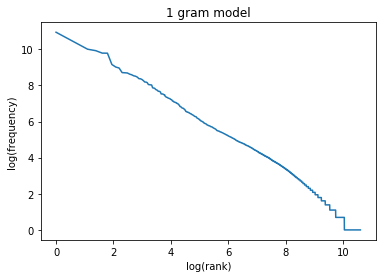

In [200]:
# Task 1
# Zif's law verification
ug.showPlot()

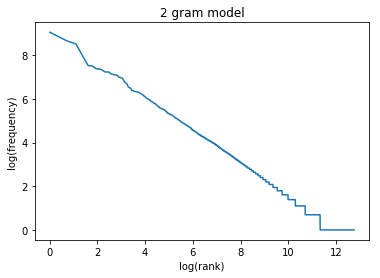

In [201]:
bg.showPlot()

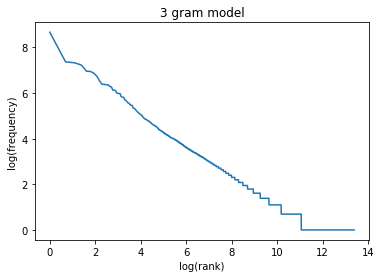

In [202]:
tg.showPlot()

In [207]:
# Task 1
# Top 10 unigrams, bigrams, trigrams
top10Uni = dict(sorted(ug.frequency().items(), key=lambda x: x[1], reverse=True)[:10])
top10Bi = dict(sorted(bg.frequency().items(), key=lambda x: x[1], reverse=True)[:10])
top10Tri = dict(sorted(tg.frequency().items(), key=lambda x: x[1], reverse=True)[:10])

print("\\textit{Top 10 unigrams:} \\\\ \\vspace{1mm}")
for c in top10Uni.items():
    print(c,'\\\\')
print('\\vspace{2mm}')
print("\\textit{Top 10 bigrams:} \\\\ \\vspace{1mm}")
for c in top10Bi.items():
    print(c,'\\\\')
print('\\vspace{2mm}')
print("\\textit{Top 10 trigrams:} \\\\ \\vspace{1mm}")
for c in top10Tri.items():
    print(c,'\\\\')

\textit{Top 10 unigrams:} \\ \vspace{1mm}
(('the',), 56448) \\
(('of',), 31276) \\
(('and',), 22092) \\
(('to',), 20341) \\
(('a',), 17780) \\
(('in',), 17705) \\
(('is',), 9474) \\
(('that',), 8240) \\
(('for',), 7788) \\
(('it',), 6051) \\
\vspace{2mm}
\textit{Top 10 bigrams:} \\ \vspace{1mm}
(('of', 'the'), 8508) \\
(('<s>', 'the'), 5798) \\
(('in', 'the'), 4985) \\
(('to', 'the'), 2819) \\
(('and', 'the'), 1848) \\
(('on', 'the'), 1821) \\
(('for', 'the'), 1591) \\
(('<s>', 'in'), 1585) \\
(('<s>', 'it'), 1516) \\
(('it', 'is'), 1390) \\
\vspace{2mm}
\textit{Top 10 trigrams:} \\ \vspace{1mm}
(('<s>', '<s>', 'the'), 5798) \\
(('<s>', '<s>', 'in'), 1585) \\
(('<s>', '<s>', 'it'), 1516) \\
(('<s>', '<s>', 'he'), 1377) \\
(('<s>', '<s>', 'this'), 1052) \\
(('<s>', '<s>', 'but'), 1038) \\
(('<s>', '<s>', 'a'), 955) \\
(('<s>', '<s>', 'and'), 831) \\
(('<s>', '<s>', 'i'), 675) \\
(('<s>', '<s>', 'they'), 590) \\


In [197]:
# Task 1
# Test cases
fd = open('test_cases.txt','r')
testcases = [sent.split() for sent in fd]
print("\\textit{Below models are run on these test examples :} \\\\ ")
for case in testcases:
    print('\\',case,'\\\\')
print('\\vspace{2mm}')

\textit{Below models are run on these test examples :} \\ 
\ ['he', 'lived', 'a', 'good', 'life'] \\
\ ['the', 'man', 'was', 'happy'] \\
\ ['the', 'person', 'was', 'good'] \\
\ ['the', 'girl', 'was', 'sad'] \\
\ ['he', 'won', 'the', 'war'] \\
\vspace{2mm}


In [190]:
#Task 1
#Log likelihood
print("\\textit{Loglikelihood for unigram model:} \\\\ \\vspace{1mm} ", ug.test(testcases),' \\\\ \\vspace{2mm}')
print("\\textit{Loglikelihood for bigram model:} \\\\ \\vspace{1mm} ",bg.test(testcases),' \\\\ \\vspace{2mm}')
print("\\textit{Loglikelihood for trigram model:} \\\\ \\vspace{1mm} ",tg.test(testcases),' \\\\ \\vspace{2mm}')

# Perplexity
print("\\textit{Perplexity for unigram model:} \\\\ \\vspace{1mm} ", ug.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')
print("\\textit{Perplexity for bigram model:} \\\\ \\vspace{1mm} ",bg.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')
print("\\textit{Perplexity for trigram model:} \\\\ \\vspace{1mm} ",tg.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')

\textit{Loglikelihood for unigram model:} \\ \vspace{1mm}  [-32.695722922858934, -23.98335809740223, -23.3121455528641, -27.22149005169346, -24.63036419583692]  \\ \vspace{2mm}
\textit{Loglikelihood for bigram model:} \\ \vspace{1mm}  [-26.764829351066595, -21.96478877084232, -24.79196977620132, -inf, -20.911162817660017]  \\ \vspace{2mm}
\textit{Loglikelihood for trigram model:} \\ \vspace{1mm}  [-inf, -inf, -inf, -inf, -15.8133804459503]  \\ \vspace{2mm}
\textit{Perplexity for unigram model:} \\ \vspace{1mm}  [0.0014457246654110034, 0.0024890864475728106, 0.002943851890789803, 0.0011078074216666035, 0.0021173477201247948]  \\ \vspace{2mm}
\textit{Perplexity for bigram model:} \\ \vspace{1mm}  [0.004734089462448352, 0.004122905306277875, 0.002033508924169896, inf, 0.005365365897345869]  \\ \vspace{2mm}
\textit{Perplexity for trigram model:} \\ \vspace{1mm}  [inf, inf, inf, inf, 0.01919040025911855]  \\ \vspace{2mm}


In [191]:
print("#########  ASSIGNMENT PART 2 ###############")
print("\\textit{\\textbf{Laplace Constant :",1e-4,"}}\\\\ \\vspace{2mm}")

ug = LanguageModel(train,1,smoothing='laplace',laplace_constant=1e-4)
bg = LanguageModel(train,2,smoothing='laplace',laplace_constant=1e-4)
tg = LanguageModel(train,3,smoothing='laplace',laplace_constant=1e-4)

#Log likelihood
print("\\textit{Loglikelihood for unigram model:} \\\\ \\vspace{1mm} ", ug.test(testcases),' \\\\ \\vspace{2mm}')
print("\\textit{Loglikelihood for bigram model:} \\\\ \\vspace{1mm} ",bg.test(testcases),' \\\\ \\vspace{2mm}')
print("\\textit{Loglikelihood for trigram model:} \\\\ \\vspace{1mm} ",tg.test(testcases),' \\\\ \\vspace{2mm}')

# Perplexity
print("\\textit{Perplexity for unigram model:} \\\\ \\vspace{1mm} ", ug.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')
print("\\textit{Perplexity for bigram model:} \\\\ \\vspace{1mm} ",bg.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')
print("\\textit{Perplexity for trigram model:} \\\\ \\vspace{1mm} ",tg.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')


print("\\textit{\\textbf{Laplace Constant :",1e-3,"}}\\\\ \\vspace{2mm}")

ug = LanguageModel(train,1,smoothing='laplace',laplace_constant=1e-3)
bg = LanguageModel(train,2,smoothing='laplace',laplace_constant=1e-3)
tg = LanguageModel(train,3,smoothing='laplace',laplace_constant=1e-3)

#Log likelihood
print("\\textit{Loglikelihood for unigram model:} \\\\ \\vspace{1mm} ", ug.test(testcases),' \\\\ \\vspace{2mm}')
print("\\textit{Loglikelihood for bigram model:} \\\\ \\vspace{1mm} ",bg.test(testcases),' \\\\ \\vspace{2mm}')
print("\\textit{Loglikelihood for trigram model:} \\\\ \\vspace{1mm} ",tg.test(testcases),' \\\\ \\vspace{2mm}')

# Perplexity
print("\\textit{Perplexity for unigram model:} \\\\ \\vspace{1mm} ", ug.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')
print("\\textit{Perplexity for bigram model:} \\\\ \\vspace{1mm} ",bg.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')
print("\\textit{Perplexity for trigram model:} \\\\ \\vspace{1mm} ",tg.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')


print("\\textit{\\textbf{Laplace Constant :",1e-2,"}}\\\\ \\vspace{2mm}")

ug = LanguageModel(train,1,smoothing='laplace',laplace_constant=1e-2)
bg = LanguageModel(train,2,smoothing='laplace',laplace_constant=1e-2)
tg = LanguageModel(train,3,smoothing='laplace',laplace_constant=1e-2)

#Log likelihood
print("\\textit{Loglikelihood for unigram model:} \\\\ \\vspace{1mm} ", ug.test(testcases),' \\\\ \\vspace{2mm}')
print("\\textit{Loglikelihood for bigram model:} \\\\ \\vspace{1mm} ",bg.test(testcases),' \\\\ \\vspace{2mm}')
print("\\textit{Loglikelihood for trigram model:} \\\\ \\vspace{1mm} ",tg.test(testcases),' \\\\ \\vspace{2mm}')

# Perplexity
print("\\textit{Perplexity for unigram model:} \\\\ \\vspace{1mm} ", ug.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')
print("\\textit{Perplexity for bigram model:} \\\\ \\vspace{1mm} ",bg.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')
print("\\textit{Perplexity for trigram model:} \\\\ \\vspace{1mm} ",tg.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')


print("\\textit{\\textbf{Laplace Constant :",1e-1,"}}\\\\ \\vspace{2mm}")

ug = LanguageModel(train,1,smoothing='laplace',laplace_constant=1e-1)
bg = LanguageModel(train,2,smoothing='laplace',laplace_constant=1e-1)
tg = LanguageModel(train,3,smoothing='laplace',laplace_constant=1e-1)

#Log likelihood
print("\\textit{Loglikelihood for unigram model:} \\\\ \\vspace{1mm} ", ug.test(testcases),' \\\\ \\vspace{2mm}')
print("\\textit{Loglikelihood for bigram model:} \\\\ \\vspace{1mm} ",bg.test(testcases),' \\\\ \\vspace{2mm}')
print("\\textit{Loglikelihood for trigram model:} \\\\ \\vspace{1mm} ",tg.test(testcases),' \\\\ \\vspace{2mm}')

# Perplexity
print("\\textit{Perplexity for unigram model:} \\\\ \\vspace{1mm} ", ug.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')
print("\\textit{Perplexity for bigram model:} \\\\ \\vspace{1mm} ",bg.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')
print("\\textit{Perplexity for trigram model:} \\\\ \\vspace{1mm} ",tg.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')


print("\\textit{\\textbf{Laplace Constant :",1,"}}\\\\ \\vspace{2mm}")

ug = LanguageModel(train,1,smoothing='laplace',laplace_constant=1)
bg = LanguageModel(train,2,smoothing='laplace',laplace_constant=1)
tg = LanguageModel(train,3,smoothing='laplace',laplace_constant=1)

#Log likelihood
print("\\textit{Loglikelihood for unigram model:} \\\\ \\vspace{1mm} ", ug.test(testcases),' \\\\ \\vspace{2mm}')
print("\\textit{Loglikelihood for bigram model:} \\\\ \\vspace{1mm} ",bg.test(testcases),' \\\\ \\vspace{2mm}')
print("\\textit{Loglikelihood for trigram model:} \\\\ \\vspace{1mm} ",tg.test(testcases),' \\\\ \\vspace{2mm}')

# Perplexity
print("\\textit{Perplexity for unigram model:} \\\\ \\vspace{1mm} ", ug.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')
print("\\textit{Perplexity for bigram model:} \\\\ \\vspace{1mm} ",bg.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')
print("\\textit{Perplexity for trigram model:} \\\\ \\vspace{1mm} ",tg.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')


#########  ASSIGNMENT PART 2 ###############
\textit{\textbf{Laplace Constant : 0.0001 }}\\ \vspace{2mm}
\textit{Loglikelihood for unigram model:} \\ \vspace{1mm}  [-32.69622080463882, -23.983756137106077, -23.312544601677335, -27.221883078197745, -24.63076229749562]  \\ \vspace{2mm}
\textit{Loglikelihood for bigram model:} \\ \vspace{1mm}  [-26.846998357382855, -22.040803342989804, -24.82913006160655, -34.54852518495259, -20.985083862349043]  \\ \vspace{2mm}
\textit{Loglikelihood for trigram model:} \\ \vspace{1mm}  [-47.891532357427565, -34.58708696948569, -34.8988415533577, -36.09567423746888, -17.2757229037102]  \\ \vspace{2mm}
\textit{Perplexity for unigram model:} \\ \vspace{1mm}  [0.001445580712584343, 0.002488838771088039, 0.0029435582202878147, 0.0011076985775944268, 0.002117137000701079]  \\ \vspace{2mm}
\textit{Perplexity for bigram model:} \\ \vspace{1mm}  [0.004656926156889749, 0.004045294861816026, 0.0020147049614884756, 0.00017739506690289528, 0.005267123106469391]  \\ \

In [192]:
print("#########  ASSIGNMENT PART 3 ###############\n Using Good-Turing smoothing")

ug = LanguageModel(train,1,smoothing='goodturing')
bg = LanguageModel(train,2,smoothing='goodturing')
tg = LanguageModel(train,3,smoothing='goodturing')

#Log likelihood
print("\\textit{Loglikelihood for unigram model:} \\\\ \\vspace{1mm} ", ug.test(testcases),' \\\\ \\vspace{2mm}')
print("\\textit{Loglikelihood for bigram model:} \\\\ \\vspace{1mm} ",bg.test(testcases),' \\\\ \\vspace{2mm}')
print("\\textit{Loglikelihood for trigram model:} \\\\ \\vspace{1mm} ",tg.test(testcases),' \\\\ \\vspace{2mm}')

# Perplexity
print("\\textit{Perplexity for unigram model:} \\\\ \\vspace{1mm} ", ug.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')
print("\\textit{Perplexity for bigram model:} \\\\ \\vspace{1mm} ",bg.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')
print("\\textit{Perplexity for trigram model:} \\\\ \\vspace{1mm} ",tg.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')


#########  ASSIGNMENT PART 3 ###############
 Using Good-Turing smoothing
\textit{Loglikelihood for unigram model:} \\ \vspace{1mm}  [-32.695722922858934, -23.98335809740223, -23.3121455528641, -27.22149005169346, -24.63036419583692]  \\ \vspace{2mm}
\textit{Loglikelihood for bigram model:} \\ \vspace{1mm}  [-inf, -inf, -inf, -inf, -inf]  \\ \vspace{2mm}
\textit{Loglikelihood for trigram model:} \\ \vspace{1mm}  [-83.51814186819102, -49.47572715485047, -50.951633674660044, -55.04597823688215, 14.082017000983676]  \\ \vspace{2mm}
\textit{Perplexity for unigram model:} \\ \vspace{1mm}  [0.0014457246654110034, 0.0024890864475728106, 0.002943851890789803, 0.0011078074216666035, 0.0021173477201247948]  \\ \vspace{2mm}
\textit{Perplexity for bigram model:} \\ \vspace{1mm}  [inf, inf, inf, inf, inf]  \\ \vspace{2mm}
\textit{Perplexity for trigram model:} \\ \vspace{1mm}  [5.568091579219525e-08, 4.248554337771141e-06, 2.9376270784963217e-06, 1.0555014887178303e-06, 33.8014685660875]  \\ \vspac

In [193]:
print("#########  ASSIGNMENT PART 4 ###############")
print("Using Interpolation smoothing with lambda ",0.2)


bg = LanguageModel(train,2,smoothing='interpolation',lambda1=0.2)
tg = LanguageModel(train,3,smoothing='interpolation',lambda1=0.2,lambda2=0.2)

#Log likelihood
print("\\textit{Loglikelihood for bigram model:} \\\\ \\vspace{1mm} ",bg.test(testcases),' \\\\ \\vspace{2mm}')
print("\\textit{Loglikelihood for trigram model:} \\\\ \\vspace{1mm} ",tg.test(testcases),' \\\\ \\vspace{2mm}')

# Perplexity
print("\\textit{Perplexity for bigram model:} \\\\ \\vspace{1mm} ",bg.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')
print("\\textit{Perplexity for trigram model:} \\\\ \\vspace{1mm} ",tg.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')


print("Using Interpolation smoothing with lambda ",0.5)
bg = LanguageModel(train,2,smoothing='interpolation',lambda1=0.5)
tg = LanguageModel(train,3,smoothing='interpolation',lambda1=0.3,lambda2=0.3)

#Log likelihood
print("\\textit{Loglikelihood for bigram model:} \\\\ \\vspace{1mm} ",bg.test(testcases),' \\\\ \\vspace{2mm}')
print("\\textit{Loglikelihood for trigram model:} \\\\ \\vspace{1mm} ",tg.test(testcases),' \\\\ \\vspace{2mm}')

# Perplexity
print("\\textit{Perplexity for bigram model:} \\\\ \\vspace{1mm} ",bg.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')
print("\\textit{Perplexity for trigram model:} \\\\ \\vspace{1mm} ",tg.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')


print("Using Interpolation smoothing with lambda ",0.8)
bg = LanguageModel(train,2,smoothing='interpolation',lambda1=0.8)
tg = LanguageModel(train,3,smoothing='interpolation',lambda1=0.5,lambda2=0.5)

#Log likelihood
print("\\textit{Loglikelihood for bigram model:} \\\\ \\vspace{1mm} ",bg.test(testcases),' \\\\ \\vspace{2mm}')
print("\\textit{Loglikelihood for trigram model:} \\\\ \\vspace{1mm} ",tg.test(testcases),' \\\\ \\vspace{2mm}')

# Perplexity
print("\\textit{Perplexity for bigram model:} \\\\ \\vspace{1mm} ",bg.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')
print("\\textit{Perplexity for trigram model:} \\\\ \\vspace{1mm} ",tg.test(testcases,type='perplexity'),' \\\\ \\vspace{2mm}')


#########  ASSIGNMENT PART 4 ###############
Using Interpolation smoothing with lambda  0.2
\textit{Loglikelihood for bigram model:} \\ \vspace{1mm}  [-32.50176303469126, -26.307329753326425, -27.29349415930528, -30.578362817575908, -26.051731897229526]  \\ \vspace{2mm}
\textit{Loglikelihood for trigram model:} \\ \vspace{1mm}  [-32.40744875947381, -26.948191267019766, -27.360427250077173, -31.354051634437806, -22.402272658399003]  \\ \vspace{2mm}
\textit{Perplexity for bigram model:} \\ \vspace{1mm}  [0.0015029091633384437, 0.0013922523628770384, 0.001088044163601919, 0.00047862616965220424, 0.0014841204462231145]  \\ \vspace{2mm}
\textit{Perplexity for trigram model:} \\ \vspace{1mm}  [0.0015315273831534204, 0.001186143706424549, 0.0010699891053037264, 0.0003942548979999028, 0.0036957633179670675]  \\ \vspace{2mm}
Using Interpolation smoothing with lambda  0.5
\textit{Loglikelihood for bigram model:} \\ \vspace{1mm}  [-29.404015414509253, -24.099194050692976, -25.976132630151266, -29